该脚本尝试使用gluon搭建一个object localizator:  
读取图像，使用浅层神经网络回归至五维向量，以获取单个目标的置信度以及位置信息

In [1]:
import os
import pdb
import mxnet as mx
import numpy as np
import gluonbook as gbk
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision
from mxnet import gluon, nd, image, autograd
import matplotlib.pyplot as plt
from mxnet import init
from mxnet.gluon import utils as gutils
%matplotlib inline

主要使用mxnet中专门用于目标检测任务的迭代器：ImageDetIter  
** class mxnet.image.ImageDetIter ** (batch_size, data_shape, path_imgrec=None, path_imglist=None, path_root=None, path_imgidx=None, shuffle=False, part_index=0, num_parts=1, aug_list=None, imglist=None, data_name='data', label_name='label', **kwargs)[source]

In [17]:
def data_iterator(batch_size, data_shape, data_root):
    #os.chdir(data_root)
    train_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape = (3, data_shape, data_shape),
        path_imgrec = data_root + '/train.rec',
        path_imgidx = data_root + '/train.idx',
        shuffle = True,
        mean = True ,
        std = True,
        rand_crop = 1,
        min_object_covered = 0.9,
        max_attempts =  200)
    val_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape = (3, data_shape, data_shape),
        path_imgrec =data_root + '/val.rec',
        path_imgidx =data_root + '/val.idx',
        shuffle = False,
        mean = True, 
        std = True)
    return train_iter, val_iter

In [18]:
BATCH_SIZE = 16
DATA_SHAPE = 256
DATA_ROOT = '/home/users/chengyuan.yang/Further_Dataset_Process/rec_dataset'
train_iter, val_iter = data_iterator(batch_size=16, data_shape=256, data_root = DATA_ROOT)

In [19]:
batch = train_iter.next()
print(batch)

DataBatch: data shapes: [(16L, 3L, 256L, 256L)] label shapes: [(16L, 1L, 5L)]


In [20]:
def box_to_rect(box, color, linewidth=3):
    box = box.asnumpy()
    #pdb.set_trace()
    return plt.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], 
                         fill=False, edgecolor=color, linewidth=linewidth)

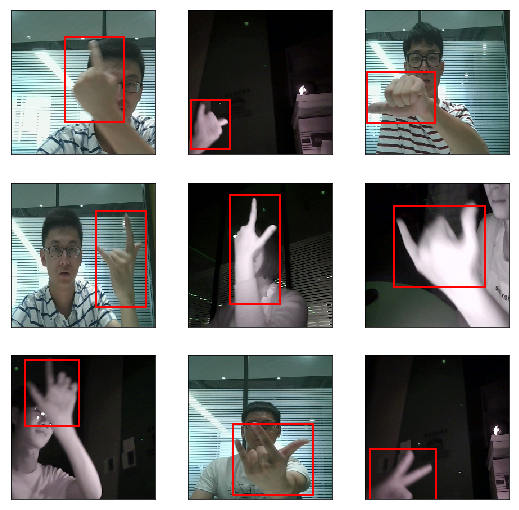

In [21]:
RGB_MEAN = nd.array([123, 117, 104])
RGB_STD = nd.array([58.395, 57.12, 57.375])

_, figs = plt.subplots(3, 3, figsize=(9,9))
for i in range(3):
    for j in range(3):
        img, label = batch.data[0][3*i+j], batch.label[0][3*i+j]
        img = img.transpose((1,2,0)) * RGB_STD + RGB_MEAN
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        rect = box_to_rect(label[0][1:5]*DATA_SHAPE , 'red', 2)
        fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

Step 2: 定义网络模型

In [22]:
pretrained = vision.resnet18_v1(pretrained=True).features
net = nn.HybridSequential()
for i in range(8):
    net.add(pretrained[i])
net.add(nn.GlobalAvgPool2D())
Dense_layer = nn.Dense(units=4)
Dense_layer.initialize()
net.add(Dense_layer)
net

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
  (2): Activation(relu)
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (4): HybridSequential(
    (0): BasicBlockV1(
      (body): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
        (2): Activation(relu)
        (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
      )
    )
    (1): BasicBlockV1(
      (body): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [23]:
#check_result:
test_input =  batch.data[0]
# test_input = test_input.expand_dims(axis = 0)
test_feature = net(test_input)
test_feature.shape

(16L, 4L)

定义loss函数：

In [24]:
l1_loss = gluon.loss.L1Loss()
l2_loss = gluon.loss.L2Loss()

定义训练函数

In [244]:
# ctx = [mx.gpu(0), mx.gpu(1), mx.gpu(2),mx.gpu(3)]
ctx = [mx.gpu(3)]
net.load_parameters('models/model_14.params')
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':0.0000005, 'wd':5e-4})

In [245]:
def transform_center(box):
    box = nd.squeeze(box)
    x1, y1, x2, y2 = box.split(num_outputs=4, axis=-1)
    x,y = (x1+x2)/2, (y1+y2)/2
    w,h = x2-x1, y2-y1
    return nd.concat(*[x,y,w,h], dim=-1)
def feature_forward(feature):
    feature = nd.squeeze(feature)
    xywh_pred = nd.sigmoid(feature)
    return xywh_pred
def my_l2_loss(X,Y):
    num_instances=X.shape[0]
    return nd.sum(nd.square(X-Y))/2/num_instances

In [ ]:
NUM_EPOCHS = 50
os.chdir('/home/users/chengyuan.yang/Pycharm_Project/hands_detector/localizator')
for epoch in range(NUM_EPOCHS):
    train_iter.reset()
    for i, batch in enumerate(train_iter):
#         x = batch.data[0].as_in_context(ctx)
#         y = batch.label[0].as_in_context(ctx)
        x = gutils.split_and_load(batch.data[0], ctx)
        y = gutils.split_and_load(batch.label[0], ctx)
        with autograd.record():
            feature = [net(x0) for x0 in x]
            #with autograd.pause():
            xywh_pred = [feature_forward(f) for f in feature]

            box_lb = [nd.slice_axis(y0, begin=1, end=5, axis=-1) for y0 in y]
            xywh_lb = [transform_center(b_l) for b_l in box_lb]
            loss = [my_l2_loss(p, l) for p, l in zip(xywh_pred, xywh_lb)]

        for l in loss:
            l.backward()
        trainer.step(BATCH_SIZE)
        
        if i % 50 ==0:
            try:
                #pdb.set_trace()
                print(xywh_pred[0][0], xywh_lb[0][0])
                #pdb.set_trace()
                loss_record = sum([nd.mean(l) for l in loss])/len(ctx)
                print('Epoch: {0}, iter: {1}, loss: {2}'.format(epoch, i, loss_record))
            except:
                #pdb.set_trace()
                print(xywh_pred[0][0], xywh_lb[0][0])
                loss_record = sum([nd.mean(l) for l in loss])/len(ctx)
                print('Epoch: {0}, iter: {1}, loss: {2}'.format(
                    epoch, i, loss_record))
    net.save_parameters('models/model_{}.params'.format(epoch))

(
[0.33645025 0.46588004 0.4170897  0.51249367]
<NDArray 4 @gpu(3)>, 
[0.23037544 0.46376812 0.46075088 0.5797101 ]
<NDArray 4 @gpu(3)>)
Epoch: 0, iter: 0, loss: 
[0.01635874]
<NDArray 1 @gpu(3)>
(
[0.470931   0.4947007  0.49551633 0.5360976 ]
<NDArray 4 @gpu(3)>, 
[0.4672727  0.53365386 0.570909   0.7083334 ]
<NDArray 4 @gpu(3)>)
Epoch: 0, iter: 50, loss: 
[0.0196331]
<NDArray 1 @gpu(3)>
(
[0.43671298 0.7475119  0.34633753 0.38456488]
<NDArray 4 @gpu(3)>, 
[0.4068136  0.8029926  0.21242481 0.29426426]
<NDArray 4 @gpu(3)>)
Epoch: 0, iter: 100, loss: 
[0.01687071]
<NDArray 1 @gpu(3)>
(
[0.43131006 0.7194559  0.36968598 0.40533778]
<NDArray 4 @gpu(3)>, 
[0.3        0.6319612  0.24905658 0.38740918]
<NDArray 4 @gpu(3)>)
Epoch: 0, iter: 150, loss: 
[0.02093012]
<NDArray 1 @gpu(3)>
(
[0.31895223 0.37917095 0.4070002  0.53840506]
<NDArray 4 @gpu(3)>, 
[0.2693837  0.2650862  0.40755466 0.5301724 ]
<NDArray 4 @gpu(3)>)
Epoch: 0, iter: 200, loss: 
[0.01553778]
<NDArray 1 @gpu(3)>
(
[0.3894016  

(
[0.7191932  0.69655937 0.29697704 0.3919886 ]
<NDArray 4 @gpu(3)>, 
[0.609375   0.7769029  0.3298611  0.39895016]
<NDArray 4 @gpu(3)>)
Epoch: 1, iter: 450, loss: 
[0.02629446]
<NDArray 1 @gpu(3)>
(
[0.5935612  0.49883127 0.42912802 0.51256967]
<NDArray 4 @gpu(3)>, 
[0.66745853 0.47638887 0.34204286 0.60833335]
<NDArray 4 @gpu(3)>)
Epoch: 1, iter: 500, loss: 
[0.01153379]
<NDArray 1 @gpu(3)>
(
[0.6116418  0.47440836 0.39695746 0.5088321 ]
<NDArray 4 @gpu(3)>, 
[0.6678201  0.43883795 0.3806229  0.61467886]
<NDArray 4 @gpu(3)>)
Epoch: 1, iter: 550, loss: 
[0.02349827]
<NDArray 1 @gpu(3)>
(
[0.3978345 0.5047728 0.3852197 0.4883245]
<NDArray 4 @gpu(3)>, 
[0.3936382  0.3791209  0.250497   0.40219784]
<NDArray 4 @gpu(3)>)
Epoch: 1, iter: 600, loss: 
[0.02412158]
<NDArray 1 @gpu(3)>
(
[0.3472771  0.71082693 0.3700452  0.40682465]
<NDArray 4 @gpu(3)>, 
[0.24576272 0.7283814  0.28389832 0.4368071 ]
<NDArray 4 @gpu(3)>)
Epoch: 1, iter: 650, loss: 
[0.01753516]
<NDArray 1 @gpu(3)>
(
[0.4810723  

(
[0.25093257 0.659872   0.33291    0.40865278]
<NDArray 4 @gpu(3)>, 
[0.1691919  0.7341269  0.3383838  0.48412699]
<NDArray 4 @gpu(3)>)
Epoch: 2, iter: 900, loss: 
[0.01417627]
<NDArray 1 @gpu(3)>
(
[0.25553373 0.6436942  0.31384903 0.40671015]
<NDArray 4 @gpu(3)>, 
[0.09381044 0.7553648  0.18762088 0.46781123]
<NDArray 4 @gpu(3)>)
Epoch: 2, iter: 950, loss: 
[0.02129211]
<NDArray 1 @gpu(3)>
(
[0.6723505  0.5368632  0.41001582 0.494293  ]
<NDArray 4 @gpu(3)>, 
[0.7669492 0.6513888 0.4661017 0.6861111]
<NDArray 4 @gpu(3)>)
Epoch: 2, iter: 1000, loss: 
[0.02168664]
<NDArray 1 @gpu(3)>
(
[0.33447802 0.7349441  0.3718755  0.39735055]
<NDArray 4 @gpu(3)>, 
[0.3651376  0.8419913  0.55412847 0.3030303 ]
<NDArray 4 @gpu(3)>)
Epoch: 2, iter: 1050, loss: 
[0.02272999]
<NDArray 1 @gpu(3)>
(
[0.42854723 0.5801137  0.41833392 0.47625074]
<NDArray 4 @gpu(3)>, 
[0.3807786  0.64135516 0.39172754 0.5070093 ]
<NDArray 4 @gpu(3)>)
Epoch: 2, iter: 1100, loss: 
[0.01741998]
<NDArray 1 @gpu(3)>
(
[0.513001

(
[0.5111569  0.5274807  0.48013157 0.52018964]
<NDArray 4 @gpu(3)>, 
[0.42757007 0.6294248  0.85514015 0.7234513 ]
<NDArray 4 @gpu(3)>)
Epoch: 3, iter: 1350, loss: 
[0.02552]
<NDArray 1 @gpu(3)>
(
[0.56845975 0.736602   0.32322186 0.3831041 ]
<NDArray 4 @gpu(3)>, 
[0.7794118  0.76802886 0.35294122 0.4639423 ]
<NDArray 4 @gpu(3)>)
Epoch: 3, iter: 1400, loss: 
[0.02756822]
<NDArray 1 @gpu(3)>
(
[0.3597625  0.67176336 0.3297714  0.40613106]
<NDArray 4 @gpu(3)>, 
[0.16983694 0.6131579  0.24728262 0.3263158 ]
<NDArray 4 @gpu(3)>)
Epoch: 3, iter: 1450, loss: 
[0.02592464]
<NDArray 1 @gpu(3)>
(
[0.4296007  0.741801   0.35958534 0.3921367 ]
<NDArray 4 @gpu(3)>, 
[0.42898273 0.7841163  0.4241843  0.3736018 ]
<NDArray 4 @gpu(3)>)
Epoch: 3, iter: 1500, loss: 
[0.01956833]
<NDArray 1 @gpu(3)>
(
[0.48905775 0.55113786 0.47182813 0.5083733 ]
<NDArray 4 @gpu(3)>, 
[0.45541406 0.59063447 0.90445864 0.60725075]
<NDArray 4 @gpu(3)>)
Epoch: 3, iter: 1550, loss: 
[0.03279883]
<NDArray 1 @gpu(3)>
(
[0.297

(
[0.34646037 0.6402175  0.40606925 0.44792277]
<NDArray 4 @gpu(3)>, 
[0.35700577 0.6782511  0.34548947 0.5044843 ]
<NDArray 4 @gpu(3)>)
Epoch: 5, iter: 150, loss: 
[0.02531474]
<NDArray 1 @gpu(3)>
(
[0.23724152 0.6518246  0.33035567 0.41015676]
<NDArray 4 @gpu(3)>, 
[0.1625222  0.68976545 0.26820606 0.47974417]
<NDArray 4 @gpu(3)>)
Epoch: 5, iter: 200, loss: 
[0.01491656]
<NDArray 1 @gpu(3)>
(
[0.5435199  0.69737184 0.34674037 0.40785366]
<NDArray 4 @gpu(3)>, 
[0.5351494  0.69047624 0.254833   0.35600913]
<NDArray 4 @gpu(3)>)
Epoch: 5, iter: 250, loss: 
[0.01332294]
<NDArray 1 @gpu(3)>
(
[0.5427852  0.71062714 0.3493647  0.40366173]
<NDArray 4 @gpu(3)>, 
[0.4905263  0.7254902  0.28210527 0.5490196 ]
<NDArray 4 @gpu(3)>)
Epoch: 5, iter: 300, loss: 
[0.01897429]
<NDArray 1 @gpu(3)>
(
[0.5415242 0.6701146 0.3797456 0.4314454]
<NDArray 4 @gpu(3)>, 
[0.6198704  0.7426108  0.48812094 0.27832508]
<NDArray 4 @gpu(3)>)
Epoch: 5, iter: 350, loss: 
[0.02536899]
<NDArray 1 @gpu(3)>
(
[0.5608902  

(
[0.5296988  0.5105559  0.39971712 0.49550498]
<NDArray 4 @gpu(3)>, 
[0.490566   0.4231975  0.25471693 0.4137931 ]
<NDArray 4 @gpu(3)>)
Epoch: 6, iter: 600, loss: 
[0.01556745]
<NDArray 1 @gpu(3)>
(
[0.41970438 0.6891924  0.3655283  0.4155556 ]
<NDArray 4 @gpu(3)>, 
[0.6185819  0.7210145  0.2738386  0.38888884]
<NDArray 4 @gpu(3)>)
Epoch: 6, iter: 650, loss: 
[0.02581454]
<NDArray 1 @gpu(3)>
(
[0.43355277 0.59643906 0.36280182 0.4487413 ]
<NDArray 4 @gpu(3)>, 
[0.48333335 0.4862069  0.2111111  0.31034482]
<NDArray 4 @gpu(3)>)
Epoch: 6, iter: 700, loss: 
[0.02436249]
<NDArray 1 @gpu(3)>
(
[0.48300764 0.75055087 0.32605156 0.37640044]
<NDArray 4 @gpu(3)>, 
[0.51115245 0.8689904  0.19330862 0.26201922]
<NDArray 4 @gpu(3)>)
Epoch: 6, iter: 750, loss: 
[0.01884701]
<NDArray 1 @gpu(3)>
(
[0.31585726 0.7576531  0.34737557 0.37769145]
<NDArray 4 @gpu(3)>, 
[0.22795498 0.8329646  0.24202627 0.27654862]
<NDArray 4 @gpu(3)>)
Epoch: 6, iter: 800, loss: 
[0.01817385]
<NDArray 1 @gpu(3)>
(
[0.43233

(
[0.58263683 0.512704   0.40221223 0.49711582]
<NDArray 4 @gpu(3)>, 
[0.70533645 0.53443116 0.28770298 0.55389225]
<NDArray 4 @gpu(3)>)
Epoch: 7, iter: 1050, loss: 
[0.03011433]
<NDArray 1 @gpu(3)>
(
[0.52070963 0.7379813  0.32642585 0.38277552]
<NDArray 4 @gpu(3)>, 
[0.49686843 0.7316076  0.18789145 0.4277929 ]
<NDArray 4 @gpu(3)>)
Epoch: 7, iter: 1100, loss: 
[0.0176429]
<NDArray 1 @gpu(3)>
(
[0.22711065 0.6283592  0.32570502 0.41635957]
<NDArray 4 @gpu(3)>, 
[0.14802632 0.6831897  0.2236842  0.46982756]
<NDArray 4 @gpu(3)>)
Epoch: 7, iter: 1150, loss: 
[0.01893504]
<NDArray 1 @gpu(3)>
(
[0.300207   0.49234793 0.3896891  0.49172488]
<NDArray 4 @gpu(3)>, 
[0.17158672 0.59191173 0.34317344 0.31617638]
<NDArray 4 @gpu(3)>)
Epoch: 7, iter: 1200, loss: 
[0.01986646]
<NDArray 1 @gpu(3)>
(
[0.33411607 0.47292936 0.4086506  0.5068175 ]
<NDArray 4 @gpu(3)>, 
[0.21428573 0.46715325 0.34857148 0.46715328]
<NDArray 4 @gpu(3)>)
Epoch: 7, iter: 1250, loss: 
[0.01625604]
<NDArray 1 @gpu(3)>
(
[0.4

(
[0.37395334 0.5913252  0.42325553 0.4729231 ]
<NDArray 4 @gpu(3)>, 
[0.26493505 0.5981087  0.3220779  0.45862877]
<NDArray 4 @gpu(3)>)
Epoch: 8, iter: 1500, loss: 
[0.03136523]
<NDArray 1 @gpu(3)>
(
[0.31232136 0.35901207 0.40552855 0.5450214 ]
<NDArray 4 @gpu(3)>, 
[0.2409091 0.25      0.4318182 0.5      ]
<NDArray 4 @gpu(3)>)
Epoch: 8, iter: 1550, loss: 
[0.02171111]
<NDArray 1 @gpu(3)>
(
[0.27213714 0.35819796 0.37286136 0.53117186]
<NDArray 4 @gpu(3)>, 
[0.23536037 0.24296674 0.47072074 0.4757033 ]
<NDArray 4 @gpu(3)>)
Epoch: 8, iter: 1600, loss: 
[0.02499283]
<NDArray 1 @gpu(3)>
(
[0.28402594 0.38945532 0.35752776 0.5139299 ]
<NDArray 4 @gpu(3)>, 
[0.19413094 0.3314121  0.38826188 0.6628242 ]
<NDArray 4 @gpu(3)>)
Epoch: 9, iter: 0, loss: 
[0.04204309]
<NDArray 1 @gpu(3)>
(
[0.5421222  0.58476084 0.43590853 0.4843664 ]
<NDArray 4 @gpu(3)>, 
[0.6076779  0.7009346  0.41011235 0.5981308 ]
<NDArray 4 @gpu(3)>)
Epoch: 9, iter: 50, loss: 
[0.02310476]
<NDArray 1 @gpu(3)>
(
[0.6258741  

(
[0.26117674 0.6365935  0.35116586 0.4251114 ]
<NDArray 4 @gpu(3)>, 
[0.12609649 0.5615213  0.25219297 0.42058164]
<NDArray 4 @gpu(3)>)
Epoch: 10, iter: 300, loss: 
[0.01499854]
<NDArray 1 @gpu(3)>
(
[0.317154   0.4956133  0.4008987  0.49559736]
<NDArray 4 @gpu(3)>, 
[0.22932331 0.5325521  0.42857143 0.4505209 ]
<NDArray 4 @gpu(3)>)
Epoch: 10, iter: 350, loss: 
[0.01568814]
<NDArray 1 @gpu(3)>
(
[0.46210435 0.57642144 0.44609284 0.4892298 ]
<NDArray 4 @gpu(3)>, 
[0.47653428 0.7341357  0.4043321  0.5054704 ]
<NDArray 4 @gpu(3)>)
Epoch: 10, iter: 400, loss: 
[0.01719458]
<NDArray 1 @gpu(3)>
(
[0.47686854 0.62748945 0.42190084 0.46216086]
<NDArray 4 @gpu(3)>, 
[0.5        0.65913975 0.45312503 0.3376344 ]
<NDArray 4 @gpu(3)>)
Epoch: 10, iter: 450, loss: 
[0.01789921]
<NDArray 1 @gpu(3)>
(
[0.377213   0.7975887  0.32542744 0.3524541 ]
<NDArray 4 @gpu(3)>, 
[0.49616858 0.8076923  0.3409962  0.38461536]
<NDArray 4 @gpu(3)>)
Epoch: 10, iter: 500, loss: 
[0.01912169]
<NDArray 1 @gpu(3)>
(
[0.

(
[0.51257503 0.50190455 0.4842266  0.53058887]
<NDArray 4 @gpu(3)>, 
[0.5244648  0.33441558 0.6880734  0.66883117]
<NDArray 4 @gpu(3)>)
Epoch: 11, iter: 750, loss: 
[0.01970471]
<NDArray 1 @gpu(3)>
(
[0.30469906 0.66286755 0.354269   0.4181008 ]
<NDArray 4 @gpu(3)>, 
[0.09773125 0.7920455  0.1954625  0.32954538]
<NDArray 4 @gpu(3)>)
Epoch: 11, iter: 800, loss: 
[0.04040577]
<NDArray 1 @gpu(3)>
(
[0.47989288 0.50916076 0.49999034 0.53326935]
<NDArray 4 @gpu(3)>, 
[0.2804878  0.36962748 0.5609756  0.40114614]
<NDArray 4 @gpu(3)>)
Epoch: 11, iter: 850, loss: 
[0.02310417]
<NDArray 1 @gpu(3)>
(
[0.2854793 0.5681905 0.372023  0.4583593]
<NDArray 4 @gpu(3)>, 
[0.2018868 0.7118056 0.3207547 0.525463 ]
<NDArray 4 @gpu(3)>)
Epoch: 11, iter: 900, loss: 
[0.0170002]
<NDArray 1 @gpu(3)>
(
[0.5076387  0.5164835  0.44435954 0.51033884]
<NDArray 4 @gpu(3)>, 
[0.45887446 0.49743587 0.39826837 0.45641026]
<NDArray 4 @gpu(3)>)
Epoch: 11, iter: 950, loss: 
[0.0168714]
<NDArray 1 @gpu(3)>
(
[0.43068144 0

(
[0.31978038 0.71115524 0.3669789  0.40505987]
<NDArray 4 @gpu(3)>, 
[0.265625   0.8090717  0.36160716 0.38185656]
<NDArray 4 @gpu(3)>)
Epoch: 12, iter: 1200, loss: 
[0.01140373]
<NDArray 1 @gpu(3)>
(
[0.5169409  0.44751614 0.42184487 0.525421  ]
<NDArray 4 @gpu(3)>, 
[0.55049264 0.37586206 0.3866995  0.6183908 ]
<NDArray 4 @gpu(3)>)
Epoch: 12, iter: 1250, loss: 
[0.02659949]
<NDArray 1 @gpu(3)>
(
[0.25779706 0.589412   0.3482338  0.44050577]
<NDArray 4 @gpu(3)>, 
[0.17322835 0.67329544 0.33070868 0.5795455 ]
<NDArray 4 @gpu(3)>)
Epoch: 12, iter: 1300, loss: 
[0.01766977]
<NDArray 1 @gpu(3)>
(
[0.58977103 0.612068   0.3942829  0.45977804]
<NDArray 4 @gpu(3)>, 
[0.5692308  0.6389831  0.3538462  0.41016957]
<NDArray 4 @gpu(3)>)
Epoch: 12, iter: 1350, loss: 
[0.01428378]
<NDArray 1 @gpu(3)>
(
[0.6890328  0.6614676  0.33313197 0.41977218]
<NDArray 4 @gpu(3)>, 
[0.8186714  0.75929976 0.25134647 0.3938731 ]
<NDArray 4 @gpu(3)>)
Epoch: 12, iter: 1400, loss: 
[0.01427846]
<NDArray 1 @gpu(3)>


(
[0.28929904 0.33775055 0.3684006  0.53755367]
<NDArray 4 @gpu(3)>, 
[0.1487414  0.2716763  0.29290622 0.3583815 ]
<NDArray 4 @gpu(3)>)
Epoch: 14, iter: 0, loss: 
[0.0169084]
<NDArray 1 @gpu(3)>
(
[0.28500894 0.66009    0.3310546  0.40911505]
<NDArray 4 @gpu(3)>, 
[0.33169937 0.6501272  0.40849677 0.34351143]
<NDArray 4 @gpu(3)>)
Epoch: 14, iter: 50, loss: 
[0.01737007]
<NDArray 1 @gpu(3)>
(
[0.6555415  0.47140995 0.37578952 0.50257796]
<NDArray 4 @gpu(3)>, 
[0.63550603 0.37243733 0.21783876 0.41230065]
<NDArray 4 @gpu(3)>)
Epoch: 14, iter: 100, loss: 
[0.01571412]
<NDArray 1 @gpu(3)>
(
[0.2622538  0.70991665 0.33354124 0.39056027]
<NDArray 4 @gpu(3)>, 
[0.16834171 0.735065   0.2964824  0.4103896 ]
<NDArray 4 @gpu(3)>)
Epoch: 14, iter: 150, loss: 
[0.02426209]
<NDArray 1 @gpu(3)>
(
[0.30544847 0.6607222  0.37636563 0.42778775]
<NDArray 4 @gpu(3)>, 
[0.24999999 0.64166665 0.40043285 0.41111106]
<NDArray 4 @gpu(3)>)
Epoch: 14, iter: 200, loss: 
[0.01174901]
<NDArray 1 @gpu(3)>
(
[0.2452

(
[0.6208524  0.5100256  0.42542255 0.50812346]
<NDArray 4 @gpu(3)>, 
[0.7115813  0.42243764 0.32293987 0.81163424]
<NDArray 4 @gpu(3)>)
Epoch: 15, iter: 450, loss: 
[0.0280202]
<NDArray 1 @gpu(3)>
(
[0.44320783 0.6593994  0.33415678 0.41482583]
<NDArray 4 @gpu(3)>, 
[0.4217391  0.6666667  0.33913043 0.39420283]
<NDArray 4 @gpu(3)>)
Epoch: 15, iter: 500, loss: 
[0.02284288]
<NDArray 1 @gpu(3)>
(
[0.40968713 0.49806762 0.35518378 0.47886577]
<NDArray 4 @gpu(3)>, 
[0.37919462 0.42808992 0.25279638 0.30337074]
<NDArray 4 @gpu(3)>)
Epoch: 15, iter: 550, loss: 
[0.02091724]
<NDArray 1 @gpu(3)>
(
[0.3495853  0.6028526  0.40124786 0.4597722 ]
<NDArray 4 @gpu(3)>, 
[0.39789474 0.45627803 0.48421058 0.35201788]
<NDArray 4 @gpu(3)>)
Epoch: 15, iter: 600, loss: 
[0.02401503]
<NDArray 1 @gpu(3)>
(
[0.29692677 0.48434693 0.38546857 0.49277997]
<NDArray 4 @gpu(3)>, 
[0.23837209 0.41231734 0.2774086  0.39874735]
<NDArray 4 @gpu(3)>)
Epoch: 15, iter: 650, loss: 
[0.0213734]
<NDArray 1 @gpu(3)>
(
[0.32

(
[0.2939237  0.65710473 0.3616101  0.42298102]
<NDArray 4 @gpu(3)>, 
[0.13636364 0.7255125  0.27272728 0.34851933]
<NDArray 4 @gpu(3)>)
Epoch: 16, iter: 900, loss: 
[0.02743359]
<NDArray 1 @gpu(3)>
(
[0.492487   0.74285334 0.334767   0.38361314]
<NDArray 4 @gpu(3)>, 
[0.4961905  0.6348449  0.23428574 0.41527444]
<NDArray 4 @gpu(3)>)
Epoch: 16, iter: 950, loss: 
[0.01385148]
<NDArray 1 @gpu(3)>
(
[0.45018288 0.4246862  0.43070868 0.5350927 ]
<NDArray 4 @gpu(3)>, 
[0.41641337 0.28051642 0.6443769  0.56103283]
<NDArray 4 @gpu(3)>)
Epoch: 16, iter: 1000, loss: 
[0.04364963]
<NDArray 1 @gpu(3)>
(
[0.5286125  0.57213455 0.4300892  0.48630232]
<NDArray 4 @gpu(3)>, 
[0.6164835  0.5566894  0.48131868 0.31972796]
<NDArray 4 @gpu(3)>)
Epoch: 16, iter: 1050, loss: 
[0.0250975]
<NDArray 1 @gpu(3)>
(
[0.6991505  0.6294016  0.35042715 0.43891773]
<NDArray 4 @gpu(3)>, 
[0.68193066 0.734375   0.3490098  0.53125   ]
<NDArray 4 @gpu(3)>)
Epoch: 16, iter: 1100, loss: 
[0.0176752]
<NDArray 1 @gpu(3)>
(
[0

(
[0.7166771  0.6821251  0.30832338 0.40240362]
<NDArray 4 @gpu(3)>, 
[0.67912084 0.7612293  0.22857141 0.33096933]
<NDArray 4 @gpu(3)>)
Epoch: 17, iter: 1350, loss: 
[0.01702211]
<NDArray 1 @gpu(3)>
(
[0.23259728 0.6939993  0.3236526  0.39183247]
<NDArray 4 @gpu(3)>, 
[0.12045889 0.7820823  0.22562142 0.4358353 ]
<NDArray 4 @gpu(3)>)
Epoch: 17, iter: 1400, loss: 
[0.02372228]
<NDArray 1 @gpu(3)>
(
[0.6271468  0.70411754 0.32362822 0.39799616]
<NDArray 4 @gpu(3)>, 
[0.66886795 0.78054297 0.2471698  0.43891406]
<NDArray 4 @gpu(3)>)
Epoch: 17, iter: 1450, loss: 
[0.02876062]
<NDArray 1 @gpu(3)>
(
[0.41702375 0.3936933  0.41902345 0.5406062 ]
<NDArray 4 @gpu(3)>, 
[0.46447366 0.42541435 0.40789473 0.6132596 ]
<NDArray 4 @gpu(3)>)
Epoch: 17, iter: 1500, loss: 
[0.01771874]
<NDArray 1 @gpu(3)>
(
[0.36386117 0.7054242  0.36865652 0.4092816 ]
<NDArray 4 @gpu(3)>, 
[0.6234004  0.8063457  0.46435097 0.37417942]
<NDArray 4 @gpu(3)>)
Epoch: 17, iter: 1550, loss: 
[0.02053844]
<NDArray 1 @gpu(3)>


(
[0.35028177 0.6737811  0.38507226 0.42764354]
<NDArray 4 @gpu(3)>, 
[0.32005492 0.7372449  0.44230765 0.41326535]
<NDArray 4 @gpu(3)>)
Epoch: 19, iter: 150, loss: 
[0.01349174]
<NDArray 1 @gpu(3)>
(
[0.3664693  0.40224916 0.44193134 0.5450894 ]
<NDArray 4 @gpu(3)>, 
[0.24922119 0.33985764 0.46105918 0.6797153 ]
<NDArray 4 @gpu(3)>)
Epoch: 19, iter: 200, loss: 
[0.01340179]
<NDArray 1 @gpu(3)>
(
[0.41372648 0.6369127  0.36130783 0.43343332]
<NDArray 4 @gpu(3)>, 
[0.48319328 0.68546635 0.24033615 0.48156187]
<NDArray 4 @gpu(3)>)
Epoch: 19, iter: 250, loss: 
[0.02439059]
<NDArray 1 @gpu(3)>
(
[0.49306026 0.49924988 0.4904867  0.53345734]
<NDArray 4 @gpu(3)>, 
[0.690534   0.37962964 0.5606796  0.63580245]
<NDArray 4 @gpu(3)>)
Epoch: 19, iter: 300, loss: 
[0.01658481]
<NDArray 1 @gpu(3)>
(
[0.49072465 0.5661613  0.40182555 0.4764258 ]
<NDArray 4 @gpu(3)>, 
[0.45528454 0.5790698  0.28861785 0.40930235]
<NDArray 4 @gpu(3)>)
Epoch: 19, iter: 350, loss: 
[0.02776178]
<NDArray 1 @gpu(3)>
(
[0.

(
[0.31420746 0.32360944 0.3438912  0.5335785 ]
<NDArray 4 @gpu(3)>, 
[0.41628444 0.2456332  0.25917435 0.47816595]
<NDArray 4 @gpu(3)>)
Epoch: 20, iter: 600, loss: 
[0.01850826]
<NDArray 1 @gpu(3)>
(
[0.66047215 0.618156   0.35865945 0.44524154]
<NDArray 4 @gpu(3)>, 
[0.75057733 0.47946858 0.26327938 0.33091784]
<NDArray 4 @gpu(3)>)
Epoch: 20, iter: 650, loss: 
[0.01575924]
<NDArray 1 @gpu(3)>
(
[0.5282057  0.54019815 0.46754354 0.5117064 ]
<NDArray 4 @gpu(3)>, 
[0.6102662  0.5560345  0.54372627 0.525862  ]
<NDArray 4 @gpu(3)>)
Epoch: 20, iter: 700, loss: 
[0.01069263]
<NDArray 1 @gpu(3)>
(
[0.44919658 0.70261234 0.32028952 0.39297023]
<NDArray 4 @gpu(3)>, 
[0.49424183 0.6588367  0.19001922 0.3243848 ]
<NDArray 4 @gpu(3)>)
Epoch: 20, iter: 750, loss: 
[0.0197841]
<NDArray 1 @gpu(3)>
(
[0.40311652 0.35443828 0.38287276 0.54022545]
<NDArray 4 @gpu(3)>, 
[0.3532197  0.23376623 0.31628788 0.46753246]
<NDArray 4 @gpu(3)>)
Epoch: 20, iter: 800, loss: 
[0.02574266]
<NDArray 1 @gpu(3)>
(
[0.3

(
[0.4261417 0.6139673 0.3802095 0.4495852]
<NDArray 4 @gpu(3)>, 
[0.447191   0.6341772  0.29213485 0.4632911 ]
<NDArray 4 @gpu(3)>)
Epoch: 21, iter: 1050, loss: 
[0.01414064]
<NDArray 1 @gpu(3)>
(
[0.61977446 0.56714207 0.42132765 0.4869783 ]
<NDArray 4 @gpu(3)>, 
[0.6735358  0.53411764 0.32321036 0.5317646 ]
<NDArray 4 @gpu(3)>)
Epoch: 21, iter: 1100, loss: 
[0.021573]
<NDArray 1 @gpu(3)>
(
[0.26397568 0.6648721  0.35082912 0.41496143]
<NDArray 4 @gpu(3)>, 
[0.22925311 0.6347439  0.42116183 0.4855234 ]
<NDArray 4 @gpu(3)>)
Epoch: 21, iter: 1150, loss: 
[0.0195632]
<NDArray 1 @gpu(3)>
(
[0.33339462 0.4530033  0.41617846 0.5167034 ]
<NDArray 4 @gpu(3)>, 
[0.19358669 0.4018987  0.38717338 0.5590717 ]
<NDArray 4 @gpu(3)>)
Epoch: 21, iter: 1200, loss: 
[0.01461268]
<NDArray 1 @gpu(3)>
(
[0.6327176  0.5157314  0.42115992 0.5048651 ]
<NDArray 4 @gpu(3)>, 
[0.8044218  0.54867256 0.3911565  0.9026549 ]
<NDArray 4 @gpu(3)>)
Epoch: 21, iter: 1250, loss: 
[0.01912376]
<NDArray 1 @gpu(3)>
(
[0.28

(
[0.6238858  0.68131477 0.32862958 0.4088064 ]
<NDArray 4 @gpu(3)>, 
[0.7515528 0.7033898 0.2028985 0.4382566]
<NDArray 4 @gpu(3)>)
Epoch: 22, iter: 1500, loss: 
[0.01928255]
<NDArray 1 @gpu(3)>
(
[0.5812351  0.7006462  0.33517155 0.40303347]
<NDArray 4 @gpu(3)>, 
[0.6599147  0.7311321  0.29211092 0.31603765]
<NDArray 4 @gpu(3)>)
Epoch: 22, iter: 1550, loss: 
[0.01702811]
<NDArray 1 @gpu(3)>
(
[0.4907122  0.4610258  0.42766532 0.52244294]
<NDArray 4 @gpu(3)>, 
[0.44726562 0.50242716 0.41015622 0.6456311 ]
<NDArray 4 @gpu(3)>)
Epoch: 22, iter: 1600, loss: 
[0.02543594]
<NDArray 1 @gpu(3)>
(
[0.7355419  0.5743984  0.37079936 0.4677035 ]
<NDArray 4 @gpu(3)>, 
[0.83599997 0.7125604  0.27199996 0.56038654]
<NDArray 4 @gpu(3)>)
Epoch: 23, iter: 0, loss: 
[0.02306648]
<NDArray 1 @gpu(3)>
(
[0.5349478  0.74644256 0.3263026  0.37973896]
<NDArray 4 @gpu(3)>, 
[0.6986755  0.81060606 0.46578375 0.3383839 ]
<NDArray 4 @gpu(3)>)
Epoch: 23, iter: 50, loss: 
[0.02269123]
<NDArray 1 @gpu(3)>
(
[0.3811

(
[0.46637812 0.3857621  0.38414192 0.5308978 ]
<NDArray 4 @gpu(3)>, 
[0.6766827  0.2671642  0.47836536 0.5343284 ]
<NDArray 4 @gpu(3)>)
Epoch: 24, iter: 300, loss: 
[0.02695863]
<NDArray 1 @gpu(3)>
(
[0.65303904 0.48821324 0.3861539  0.500928  ]
<NDArray 4 @gpu(3)>, 
[0.7297688  0.35189572 0.40751445 0.62322277]
<NDArray 4 @gpu(3)>)
Epoch: 24, iter: 350, loss: 
[0.01932577]
<NDArray 1 @gpu(3)>
(
[0.49817443 0.7037871  0.3482043  0.4051274 ]
<NDArray 4 @gpu(3)>, 
[0.5273973  0.7007481  0.28375727 0.5187032 ]
<NDArray 4 @gpu(3)>)
Epoch: 24, iter: 400, loss: 
[0.01815454]
<NDArray 1 @gpu(3)>
(
[0.28613523 0.40706563 0.3880064  0.5201414 ]
<NDArray 4 @gpu(3)>, 
[0.24631266 0.36470592 0.48082593 0.4294118 ]
<NDArray 4 @gpu(3)>)
Epoch: 24, iter: 450, loss: 
[0.01337883]
<NDArray 1 @gpu(3)>
(
[0.30691805 0.70187914 0.35092062 0.40222228]
<NDArray 4 @gpu(3)>, 
[0.20621471 0.735698   0.27683613 0.42334098]
<NDArray 4 @gpu(3)>)
Epoch: 24, iter: 500, loss: 
[0.02046534]
<NDArray 1 @gpu(3)>
(
[0.

(
[0.6634574  0.59737617 0.38452932 0.4631185 ]
<NDArray 4 @gpu(3)>, 
[0.8272311  0.6657382  0.26773453 0.5459611 ]
<NDArray 4 @gpu(3)>)
Epoch: 25, iter: 750, loss: 
[0.01556925]
<NDArray 1 @gpu(3)>
(
[0.3121912  0.73492223 0.3626537  0.39373982]
<NDArray 4 @gpu(3)>, 
[0.23925234 0.79333335 0.37383178 0.4133333 ]
<NDArray 4 @gpu(3)>)
Epoch: 25, iter: 800, loss: 
[0.01679839]
<NDArray 1 @gpu(3)>
(
[0.34463423 0.773305   0.3562038  0.37540084]
<NDArray 4 @gpu(3)>, 
[0.26808512 0.8447059  0.32340425 0.31058824]
<NDArray 4 @gpu(3)>)
Epoch: 25, iter: 850, loss: 
[0.02449148]
<NDArray 1 @gpu(3)>
(
[0.41048148 0.56653094 0.4360744  0.48772827]
<NDArray 4 @gpu(3)>, 
[0.35523614 0.75066316 0.43942505 0.49867374]
<NDArray 4 @gpu(3)>)
Epoch: 25, iter: 900, loss: 
[0.0120573]
<NDArray 1 @gpu(3)>
(
[0.23002417 0.61672604 0.3297326  0.4225432 ]
<NDArray 4 @gpu(3)>, 
[0.18476191 0.5903615  0.20190477 0.27469876]
<NDArray 4 @gpu(3)>)
Epoch: 25, iter: 950, loss: 
[0.01118074]
<NDArray 1 @gpu(3)>
(
[0.3

(
[0.42189646 0.5290146  0.46246132 0.51102877]
<NDArray 4 @gpu(3)>, 
[0.2947214  0.5403423  0.47800583 0.5574572 ]
<NDArray 4 @gpu(3)>)
Epoch: 26, iter: 1200, loss: 
[0.01744372]
<NDArray 1 @gpu(3)>
(
[0.40928176 0.70007193 0.35268533 0.4063059 ]
<NDArray 4 @gpu(3)>, 
[0.4279476  0.6746988  0.1790393  0.29397595]
<NDArray 4 @gpu(3)>)
Epoch: 26, iter: 1250, loss: 
[0.03951828]
<NDArray 1 @gpu(3)>
(
[0.35752964 0.46117485 0.37046206 0.4963603 ]
<NDArray 4 @gpu(3)>, 
[0.37094158 0.371875   0.25162345 0.34375   ]
<NDArray 4 @gpu(3)>)
Epoch: 26, iter: 1300, loss: 
[0.02009351]
<NDArray 1 @gpu(3)>
(
[0.43596545 0.4403178  0.45762828 0.53968585]
<NDArray 4 @gpu(3)>, 
[0.4214502  0.32432434 0.4622357  0.59459466]
<NDArray 4 @gpu(3)>)
Epoch: 26, iter: 1350, loss: 
[0.02182505]
<NDArray 1 @gpu(3)>
(
[0.3846777  0.3641184  0.38363075 0.53646606]
<NDArray 4 @gpu(3)>, 
[0.3197556  0.33901918 0.27291247 0.46055436]
<NDArray 4 @gpu(3)>)
Epoch: 26, iter: 1400, loss: 
[0.01774759]
<NDArray 1 @gpu(3)>


(
[0.3770619  0.7117881  0.39693284 0.41829297]
<NDArray 4 @gpu(3)>, 
[0.46296299 0.77735364 0.60113966 0.38422388]
<NDArray 4 @gpu(3)>)
Epoch: 28, iter: 0, loss: 
[0.01843293]
<NDArray 1 @gpu(3)>
(
[0.5189947  0.50230414 0.47022706 0.5254521 ]
<NDArray 4 @gpu(3)>, 
[0.5692771  0.5143885  0.54216874 0.9136691 ]
<NDArray 4 @gpu(3)>)
Epoch: 28, iter: 50, loss: 
[0.02977639]
<NDArray 1 @gpu(3)>
(
[0.38027233 0.6717606  0.42005095 0.44294152]
<NDArray 4 @gpu(3)>, 
[0.33598727 0.7541766  0.6082803  0.37231505]
<NDArray 4 @gpu(3)>)
Epoch: 28, iter: 100, loss: 
[0.01388089]
<NDArray 1 @gpu(3)>
(
[0.49292967 0.58760065 0.45341855 0.4891347 ]
<NDArray 4 @gpu(3)>, 
[0.5668605  0.77411765 0.5910853  0.4517647 ]
<NDArray 4 @gpu(3)>)
Epoch: 28, iter: 150, loss: 
[0.02281076]
<NDArray 1 @gpu(3)>
(
[0.28344607 0.47644928 0.38066024 0.49320835]
<NDArray 4 @gpu(3)>, 
[0.2318182  0.5052083  0.41515148 0.6006944 ]
<NDArray 4 @gpu(3)>)
Epoch: 28, iter: 200, loss: 
[0.01864396]
<NDArray 1 @gpu(3)>
(
[0.284

(
[0.3386079  0.68679726 0.37679085 0.4193001 ]
<NDArray 4 @gpu(3)>, 
[0.33646113 0.7394366  0.37801608 0.45539916]
<NDArray 4 @gpu(3)>)
Epoch: 29, iter: 450, loss: 
[0.01719657]
<NDArray 1 @gpu(3)>
(
[0.4462638  0.6691436  0.3619132  0.42275733]
<NDArray 4 @gpu(3)>, 
[0.35853133 0.6493212  0.26781857 0.38461536]
<NDArray 4 @gpu(3)>)
Epoch: 29, iter: 500, loss: 
[0.01761854]
<NDArray 1 @gpu(3)>
(
[0.54150206 0.6960054  0.3533689  0.41134265]
<NDArray 4 @gpu(3)>, 
[0.874498   0.72669494 0.25100404 0.36440676]
<NDArray 4 @gpu(3)>)
Epoch: 29, iter: 550, loss: 
[0.02248903]
<NDArray 1 @gpu(3)>
(
[0.5363167  0.72134334 0.30836633 0.3827241 ]
<NDArray 4 @gpu(3)>, 
[0.49021354 0.6670507  0.2864769  0.22811067]
<NDArray 4 @gpu(3)>)
Epoch: 29, iter: 600, loss: 
[0.01824681]
<NDArray 1 @gpu(3)>
(
[0.5488652  0.62235296 0.39635074 0.45605275]
<NDArray 4 @gpu(3)>, 
[0.7230392  0.6716937  0.2745098  0.31786543]
<NDArray 4 @gpu(3)>)
Epoch: 29, iter: 650, loss: 
[0.01681712]
<NDArray 1 @gpu(3)>
(
[0.

(
[0.45759955 0.4515658  0.45602643 0.5357843 ]
<NDArray 4 @gpu(3)>, 
[0.36556602 0.2466368  0.73113203 0.4932736 ]
<NDArray 4 @gpu(3)>)
Epoch: 30, iter: 900, loss: 
[0.02709323]
<NDArray 1 @gpu(3)>
(
[0.25067076 0.5636025  0.3487455  0.44957185]
<NDArray 4 @gpu(3)>, 
[0.14981619 0.460241   0.20404412 0.3855422 ]
<NDArray 4 @gpu(3)>)
Epoch: 30, iter: 950, loss: 
[0.02486515]
<NDArray 1 @gpu(3)>
(
[0.2997141  0.6556189  0.3697447  0.42717054]
<NDArray 4 @gpu(3)>, 
[0.16219237 0.7347162  0.32438475 0.28165936]
<NDArray 4 @gpu(3)>)
Epoch: 30, iter: 1000, loss: 
[0.02536052]
<NDArray 1 @gpu(3)>
(
[0.550284   0.5038598  0.46671072 0.52437156]
<NDArray 4 @gpu(3)>, 
[0.67790264 0.4288618  0.59925103 0.6056911 ]
<NDArray 4 @gpu(3)>)
Epoch: 30, iter: 1050, loss: 
[0.01084851]
<NDArray 1 @gpu(3)>
(
[0.28712988 0.71927416 0.3173978  0.38128388]
<NDArray 4 @gpu(3)>, 
[0.08601134 0.82307696 0.17202269 0.35384613]
<NDArray 4 @gpu(3)>)
Epoch: 30, iter: 1100, loss: 
[0.01389615]
<NDArray 1 @gpu(3)>
(


(
[0.47703636 0.68856734 0.3895666  0.42709547]
<NDArray 4 @gpu(3)>, 
[0.5744921  0.7742981  0.5620768  0.45140386]
<NDArray 4 @gpu(3)>)
Epoch: 31, iter: 1350, loss: 
[0.02805807]
<NDArray 1 @gpu(3)>
(
[0.4800083  0.4816162  0.3984476  0.50373226]
<NDArray 4 @gpu(3)>, 
[0.4650901  0.4934498  0.31306306 0.41048038]
<NDArray 4 @gpu(3)>)
Epoch: 31, iter: 1400, loss: 
[0.01602971]
<NDArray 1 @gpu(3)>
(
[0.2944903  0.7208766  0.35917422 0.3977623 ]
<NDArray 4 @gpu(3)>, 
[0.17876107 0.7770115  0.35398233 0.44597697]
<NDArray 4 @gpu(3)>)
Epoch: 31, iter: 1450, loss: 
[0.01743733]
<NDArray 1 @gpu(3)>
(
[0.24936104 0.71763283 0.3123755  0.3787523 ]
<NDArray 4 @gpu(3)>, 
[0.1902174  0.7560096  0.35326087 0.3341347 ]
<NDArray 4 @gpu(3)>)
Epoch: 31, iter: 1500, loss: 
[0.0223663]
<NDArray 1 @gpu(3)>
(
[0.46437967 0.664388   0.40503603 0.44204596]
<NDArray 4 @gpu(3)>, 
[0.5560472  0.51144165 0.6519174  0.62013733]
<NDArray 4 @gpu(3)>)
Epoch: 31, iter: 1550, loss: 
[0.01669249]
<NDArray 1 @gpu(3)>
(

(
[0.27058104 0.37455523 0.3807377  0.5283322 ]
<NDArray 4 @gpu(3)>, 
[0.24487707 0.43810678 0.48975414 0.5509708 ]
<NDArray 4 @gpu(3)>)
Epoch: 33, iter: 150, loss: 
[0.02186109]
<NDArray 1 @gpu(3)>
(
[0.4354688  0.7464036  0.34463242 0.38497373]
<NDArray 4 @gpu(3)>, 
[0.31829897 0.8383298  0.4097938  0.32334042]
<NDArray 4 @gpu(3)>)
Epoch: 33, iter: 200, loss: 
[0.02053038]
<NDArray 1 @gpu(3)>
(
[0.28796113 0.56191117 0.3766699  0.46271774]
<NDArray 4 @gpu(3)>, 
[0.3170213  0.6740947  0.29787236 0.6518106 ]
<NDArray 4 @gpu(3)>)
Epoch: 33, iter: 250, loss: 
[0.0207935]
<NDArray 1 @gpu(3)>
(
[0.22336951 0.34579894 0.34809577 0.5239689 ]
<NDArray 4 @gpu(3)>, 
[0.25053763 0.28109452 0.34193552 0.5472637 ]
<NDArray 4 @gpu(3)>)
Epoch: 33, iter: 300, loss: 
[0.02454126]
<NDArray 1 @gpu(3)>
(
[0.76035494 0.5383294  0.36324772 0.47770998]
<NDArray 4 @gpu(3)>, 
[0.72832984 0.45842957 0.25581396 0.4965358 ]
<NDArray 4 @gpu(3)>)
Epoch: 33, iter: 350, loss: 
[0.01320685]
<NDArray 1 @gpu(3)>
(
[0.3

(
[0.5559787  0.62329423 0.4078595  0.4604345 ]
<NDArray 4 @gpu(3)>, 
[0.5621693  0.65183246 0.4206349  0.48691106]
<NDArray 4 @gpu(3)>)
Epoch: 34, iter: 600, loss: 
[0.01713952]
<NDArray 1 @gpu(3)>
(
[0.3698314  0.40016344 0.4401286  0.5452637 ]
<NDArray 4 @gpu(3)>, 
[0.2862233  0.4464789  0.47743472 0.66760564]
<NDArray 4 @gpu(3)>)
Epoch: 34, iter: 650, loss: 
[0.02123555]
<NDArray 1 @gpu(3)>
(
[0.38831308 0.43820408 0.43208224 0.52946025]
<NDArray 4 @gpu(3)>, 
[0.37110484 0.43939394 0.37393773 0.5324676 ]
<NDArray 4 @gpu(3)>)
Epoch: 34, iter: 700, loss: 
[0.01896622]
<NDArray 1 @gpu(3)>
(
[0.2872673  0.5963495  0.37071416 0.44843134]
<NDArray 4 @gpu(3)>, 
[0.23790324 0.70790815 0.3387097  0.5841837 ]
<NDArray 4 @gpu(3)>)
Epoch: 34, iter: 750, loss: 
[0.02427866]
<NDArray 1 @gpu(3)>
(
[0.6784137  0.60632837 0.37494835 0.45652625]
<NDArray 4 @gpu(3)>, 
[0.72474223 0.63235295 0.27422678 0.48529404]
<NDArray 4 @gpu(3)>)
Epoch: 34, iter: 800, loss: 
[0.01536968]
<NDArray 1 @gpu(3)>
(
[0.

In [148]:
ctx = ctx[0]

In [109]:
net.load_parameters('models/model_1.params')

In [232]:
val_batch = val_iter.next()
val_img, val_label = val_batch.data[0].as_in_context(ctx), val_batch.label[0].as_in_context(ctx)
val_op = net(val_img)
xywh_pred = feature_forward(val_op)
box_lb = nd.slice_axis(val_label, begin=1, end=5, axis=-1)
xywh_lb = transform_center(box_lb)
l2_loss(xywh_pred, xywh_lb)


[0.00387251 0.00323047 0.00249552 0.00040884 0.00165691 0.00065679
 0.00410762 0.00666379 0.00111052 0.00397795 0.00319161 0.00074172
 0.00273824 0.00152805 0.00407645 0.00442366]
<NDArray 16 @gpu(3)>

In [206]:
my_l2_loss(xywh_pred, xywh_lb)


[0.01523892]
<NDArray 1 @gpu(3)>

In [121]:
def xywh2box(xywh):
    half_w = xywh[:,2]/2
    half_h = xywh[:,3]/2
    #pdb.set_trace()
    x1, y1 = xywh[:,0]-half_w, xywh[:,1]-half_h
    x2, y2 = xywh[:,0]+half_w, xywh[:,1]+half_h
    x1 = x1.reshape(-1,1)
    y1 = y1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    y2 = y2.reshape(-1,1)
    #pdb.set_trace()
    return nd.concat(*[x1,y1,x2,y2], dim=-1).reshape(-1,4)

In [152]:
xywh_pred[2]


[0.18951483 0.32168075 0.3210082  0.52041197]
<NDArray 4 @gpu(3)>

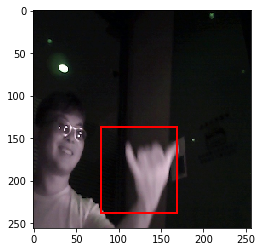

In [241]:
RGB_STD = RGB_STD.as_in_context(ctx)
RGB_MEAN = RGB_MEAN.as_in_context(ctx)
IND = 4
box = xywh2box(xywh_pred)
plt.imshow(np.uint8((val_img[IND].transpose((1,2,0))* RGB_STD + RGB_MEAN).asnumpy()))
rect = box_to_rect(box[IND]*DATA_SHAPE , 'red', 2)
plt.gca().add_patch(rect)
plt.show()

In [46]:
net2 = nn.HybridSequential()
for i in range(len(net)-2):
    net2.add(net[i])

In [56]:
nd.squeeze(y).shape

(16, 5)

In [51]:
xywh_pred.shape

(16, 4)